# Reverse Image Search (Content Based Image Retrieval) using low-dimensional embeddings

## Objective

Given an image, find other similar images from a learned set of images.

### Use Cases

- Find similar images (or duplicates)
- Find source image (e.g. which directory / link it originated from) regardless of if the image has the same name or not
- If image has multiple versions at different resolutions, can find all of them
- Copyright violation detection

### Advantages

- No human metadata labeling required
- Analyze images based on shapes / tones / textures w/in each image

### Disadvantages

- Slow, especially on large image set
- Requires some hyperparameter tuning
- Likely does not work well on images that have been flipped or rotated

### Examples of Existing Implementations

- Google Image Search
- TinEye
- [image-match](https://github.com/rhsimplex/image-match) (Opensource but no longer maintained)
- [ImageHash](https://github.com/JohannesBuchner/imagehash) (Opensource, has multiple image hashing algorithms)

### Why roll my own implementation?

- To see if I could
- Privacy: allows me to search similar images from my private albums, instead of uploading to some web service by Google or TinEye
- The advantages of both `image-match` and `ImageHash` are that they are much faster than this implementation due to simpler hashing / signature calculations
- This implementation maybe more accurate than the above opensource implementation since the low-dimensional embeddings were tuned specifically for each dataset, i.e. data points (images) more similar to each other are moved closer and points more different are pushed further apart in the low-Dimensional manifold
- Additionally, the former implementations were designed specifically to images, while this approach can be re-tooled to be applied to any data type (e.g. audio or texts) as long as they can be converted to numbers



## Implementation Overview

A `CBIR` class is built to the following framework:

1. Walk the path, seach and store all image names
2. Build an image array with `PIL` by processing each image as followed:
    - Convert to greyscale
    - Resize to 64x64
    - Reshape to a 1-Dimensional array (i.e. shape 1x4096)
3. Fit UMAP (Uniform Manifold Approximation & Projection) algorithm with the following hyperparemeters
    - w/ specified `n_neighs` neighbors (this is to be tuned)
    - w/ specified `n_comps` components (i.e. dimensions) (select an appropriate number based on speed and compute power availability)
    - `min_d` = 0.0 for `min_dist` (pre-set so that similar points clump together)
4. Tune the `n_neighs` hyperparameter by calculating the `trustworthiness` score
    - The trustworthiness score ranges from 0 to 1, with the higher end indicating a better lower dimensional representation of the dataset
    - Plot `trustworthiness` score versus `k` neighbors
    - Select an appropriate `k` neighbors
    - [Trustworthiness Score](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html)
6. Plug the `n_neighs` = `k` neighbors from the previous step to the final model
7. Save final model
8. Query an image against the built dataset as desired

## Codes

In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)


import pathlib
import joblib
import numpy as np
import os
import sklearn
import sys
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors
from umap import validation
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import trange, tqdm
from PIL import Image


class CBIR:
    __slots__ = (
        "dir",
        "EXTS",
        "files",
        "iarr",
        "imgshape",
        "umap",
        "n_comps",
        "n_neighs",
        "tfiles",
        "min_d",
        "t_score",
    )

    def __init__(self, dir: Path, files=None, n_neighs=10, n_comps=300):
        self.n_neighs = n_neighs
        self.n_comps = n_comps
        self.min_d = 0.0
        self.EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".svg"}
        self.imgshape = (64, 64)
        self.tfiles = []

        # load the preprocessed (grayscaled / resized) image array if available
        if files and Path(files).exists():
            self.files = tuple(joblib.load(Path(files)).keys())
            self.iarr = np.array(list(joblib.load(Path(files)).values()))

        # else walk the `dir` path and build the array
        elif dir and Path(dir).exists():
            self.dir = dir.resolve()
            self.files = tuple(file for file in self.walk())
            self.iarr = self.build_image_array()
        else:
            sys.exit(1)

    def walk(self):
        """
        This generator walks the path set by self.dir
        for all images in self.EXTS and yields the path
        """

        for path in self.dir.glob("**/*"):
            if (
                (path.suffix.lower() in self.EXTS)
                and (path.exists())
                and (path.is_file())
                and not (path.is_symlink())
            ):
                yield path

    def process_image(self, path_name):
        """
        This function tries to read, convert to greyscale and resize a single image.
        It then convert it to a 1-D numpy array.
        If image is corrupted, returns None.
        """
        try:
            return np.asarray(
                Image.open(path_name).convert("L").resize(self.imgshape, Image.LANCZOS)
            ).reshape(-1)
        except:
            return None

    def build_image_array(self):
        """
        This function builds a numpy array of all images with
        dimensions: (number of images x 4096 features).
        It parallel processes the process_image function for speed.
        It then saves the images in a dictionary with path name as key and 1-D numpy array as values
        in a compressed joblib pickle file.
        It returns the numpy array of images.
        """
        with ProcessPoolExecutor(max_workers=8) as exc:
            for res in tqdm(
                exc.map(self.process_image, self.files, chunksize=16),
                total=len(self.files),
            ):
                self.tfiles.append(res)

        joblib.dump(
            {
                i: j
                for i, j in zip(self.files, self.tfiles)
                if isinstance(j, np.ndarray)
            },
            "cbir_image_dict_filenames_1D_array.joblib.gz",
            compress=9,
        )

        self.files = tuple(
            i for i, j in zip(self.files, self.tfiles) if isinstance(j, np.ndarray)
        )

        return np.asarray([j for j in self.tfiles if isinstance(j, np.ndarray)])

    def run(self):
        """
        This function loads the saved model if existed,
        else it initializes the UMAP class and tries to fit.
        It saves the umap model object to self.umap and the trustworthiness score to self.t_score.
        """
        if Path(
            f"cbir_model_nn_{self.n_neighs}_comps_{self.n_comps}.joblib.gz"
        ).exists():
            self.umap = joblib.load(
                Path(f"cbir_model_nn_{self.n_neighs}_comps_{self.n_comps}.joblib.gz")
            )
        else:
            self.umap = umap.UMAP(
                n_jobs=-1,
                n_neighbors=self.n_neighs,
                n_components=self.n_comps,
                min_dist=self.min_d,
            )

            try:
                self.umap.fit(X=self.iarr)
                self.t_score = trustworthiness(
                    X=self.iarr,
                    X_embedded=self.umap.embedding_,
                    n_neighbors=self.n_neighs,
                )
            except:
                print(
                    f"n_neighs ({self.n_neighs}) should be more than 1 and less than half the number of samples ({self.iarr.shape[0]})."
                )
                sys.exit(1)

    def update(self):
        if Path(
            f"cbir_model_nn_{self.n_neighs}_comps_{self.n_comps}.joblib.gz"
        ).exists():
            self.umap = joblib.load(
                Path(f"cbir_model_nn_{self.n_neighs}_comps_{self.n_comps}.joblib.gz")
            )

            try:
                self.umap.update(X=self.iarr)
                self.t_score = trustworthiness(
                    X=self.iarr,
                    X_embedded=self.umap.embedding_,
                    n_neighbors=self.n_neighs,
                )
            except:
                print(
                    f"n_neighs ({self.n_neighs}) should be more than 1 and less than half the number of samples ({self.iarr.shape[0]})."
                )
                sys.exit(1)
        else:
            self.run()

    def query(self, q_img, n_samples):
        """
        This function queries the image for similar given images,
        given the path to the query image: q_img
        and the number of results / samples desired.
        It returns the path to the similar images previously fitted by the model.
        """
        query_img = self.process_image(Path(q_img).resolve())

        if query_img.ndim == 1:
            query_img = np.expand_dims(query_img, 0)

        query_emb = self.umap.transform(query_img)

        neigh = NearestNeighbors(
            n_neighbors=self.n_neighs, radius=self.min_d, n_jobs=-1
        )
        neigh.fit(self.umap.embedding_)

        NN_out = neigh.kneighbors(
            query_emb, n_neighbors=n_samples, return_distance=False
        )

        res = {
            str(q_img): [
                str(self.files[neighbor].resolve())
                for neighbors in NN_out
                for neighbor in neighbors
            ]
        }
        return res

    def save(self):
        """
        This function saves the umap model in a compressed joblib pickle file.
        """
        model_name = f"cbir_model_nn_{self.n_neighs}_comps_{self.n_comps}.joblib.gz"

        print(f"Saving model to file {model_name}")

        joblib.dump(
            self.umap,
            model_name,
            compress=9,
        )


## n_neighs hyperparameter tuning

### tries various n_neighs, get the truthworthiness scores

In [2]:
wdir = pathlib.Path('/home/huy/wallpapers/').expanduser()

neighs = list(range(40))
scores = []

for n in neighs:
    try:
        cb = CBIR(dir=wdir, files='cbir_image_dict_filenames_1D_array.joblib.gz', n_comps=300, n_neighs=n)
        cb.run()
        scores.append(cb.t_score)
    except:
        scores.append(0)

n_neighs (0) should be more than 1 and less than half the number of samples (37).
n_neighs (1) should be more than 1 and less than half the number of samples (37).
n_neighs (3) should be more than 1 and less than half the number of samples (37).
n_neighs (4) should be more than 1 and less than half the number of samples (37).
n_neighs (5) should be more than 1 and less than half the number of samples (37).
n_neighs (6) should be more than 1 and less than half the number of samples (37).
n_neighs (7) should be more than 1 and less than half the number of samples (37).
n_neighs (8) should be more than 1 and less than half the number of samples (37).
n_neighs (9) should be more than 1 and less than half the number of samples (37).
n_neighs (10) should be more than 1 and less than half the number of samples (37).
n_neighs (11) should be more than 1 and less than half the number of samples (37).
n_neighs (12) should be more than 1 and less than half the number of samples (37).
n_neighs (13)

### Plot Truthworthiness Score versus k neighbor

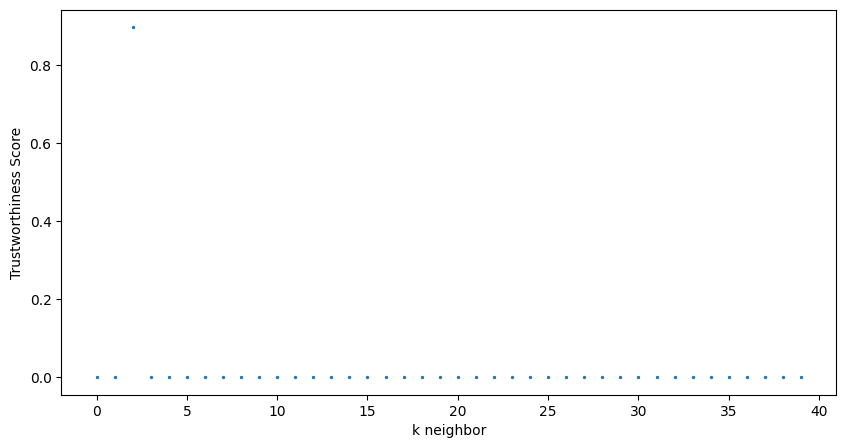

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(neighs, scores, s=2)
ax.set_xlabel('k neighbor')
ax.set_ylabel('Trustworthiness Score')
plt.show()

### find optimal number of neighbor that gives highest truthworthiness score

In [4]:
def argmax(scores):
    return max(range(len(scores)), key=lambda i: scores[i])

optimal_n = argmax(scores)
print(optimal_n)

2


## Run final model with optimal hyperparameter and saves

In [5]:
cb = CBIR(dir=wdir, files='cbir_image_dict_filenames_1D_array.joblib.gz', n_comps=300, n_neighs=optimal_n)
cb.run()
cb.save()

Saving model to file cbir_model_nn_2_comps_300.joblib.gz


## Query

In [6]:
qim = pathlib.Path('/home/huy/wallpapers/apod/CarNorth_Taylor_6179.jpg').expanduser()

results = cb.query(qim, 8)

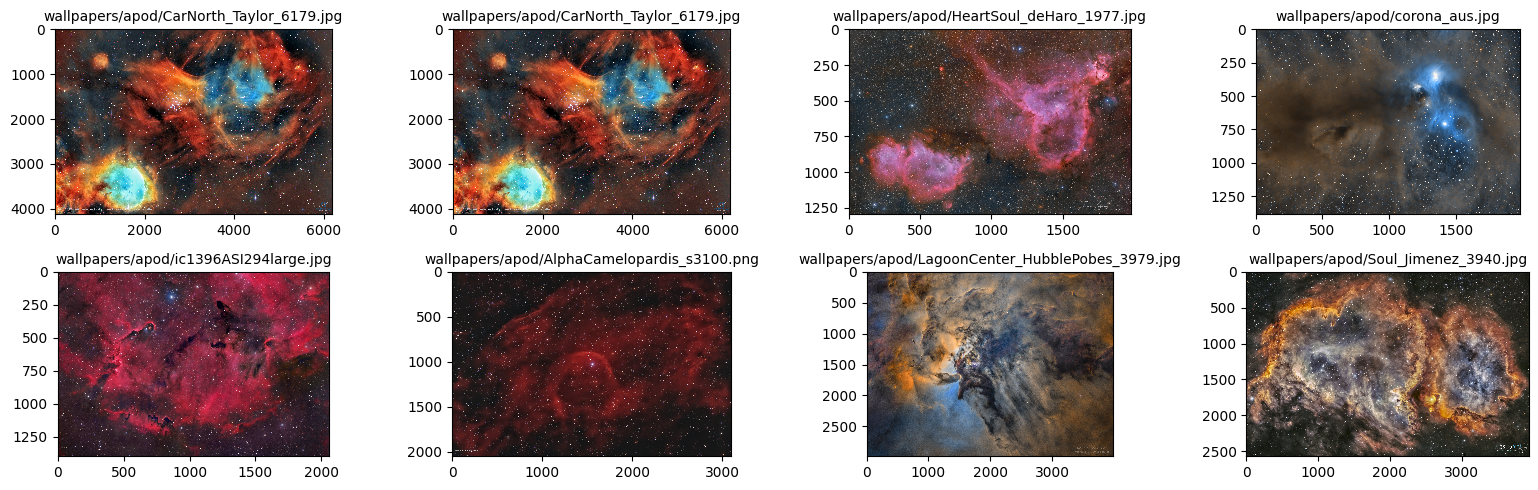

In [7]:
from skimage import io

for k,v in results.items():
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,5))
    io.imshow(k, ax=ax.flat[0])
    ax.flat[0].set_title('/'.join(pathlib.Path(k).parts[-3:]), fontsize=10)

    for a,i in zip(ax.flat[1:], v):
        io.imshow(i, ax=a)
        a.set_title('/'.join(pathlib.Path(i).parts[-3:]), fontsize=10)

    fig.set_layout_engine('tight')
    plt.show()